参考：[隠れマルコフモデルをざっくり理解したい](https://qiita.com/s-kojima1227/items/36e2468570c9bc62a481)

In [1]:
import numpy as np
import numpy.linalg as LA
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [9]:
# モデルの自由度
K = 2
D = 6
# 遷移確率
A_transition = np.array([
    [0.9, 0.1],
    [0.1, 0.9]
])
# 潜在変数で条件づけられた観測変数の出力確率
B_emission = np.array([
    [1./6.]*6,
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.5]
])
# 混合係数
pi = np.array(
    [1., 0.]
)

# 繰り返し上限
T = 10

# 観測データ列
x = np.array([
    4, 4, 5, 4, 2, 3, 3, 6, 4, 5, 5, 3, 4, 4, 1, 4, 5, 3, 6, 5,
    3, 3, 3, 5, 5, 3, 5, 6, 5, 5, 1, 3, 4, 3, 1, 2, 6, 1, 6, 1,
    5, 4, 2, 4, 1, 5, 4, 1, 1, 1, 1, 5, 6, 6, 6, 6, 1, 6, 2, 6,
    2, 6, 1, 6, 6, 6, 6, 6, 3, 2, 6, 6, 6, 1, 6, 6, 2, 6, 6, 5,
    6, 6, 5, 6, 6, 6, 6, 4, 3, 6, 6, 5, 2, 5, 4, 5, 6, 5, 4, 4
])
for i in range(x.shape[0]):
    x[i] -= 1

In [3]:
def forward(x, A_transition, B_emission, pi):
    N = x.shape[0]
    # K = A_transition.shape[0]
    # D = B_emission.shape[1]
    alpha = np.zeros((N, K))

    alpha[0, :] = pi * B_emission[:, x[0]]

    for n in range(1, N):
        for k in range(K):
            alpha[n, k] = B_emission[k, x[n]] * (alpha[n-1, :] @ A_transition[:, k])

    # print(alpha[N-1, :])
    return alpha

In [22]:
def backward(x, A_transition, B_emission, pi):
    N = x.shape[0]
    # K = A_transition.shape[0]
    # D = B_emission.shape[1]
    beta = np.zeros((N, K))

    beta[N-1] = np.ones((K))

    for n in reversed(range(0, N-1)):
        for k in range(K):
            beta[n, k] = np.sum(beta[n+1, :] @ B_emission[:, x[n]] @ A_transition[k, :])

    return beta

In [5]:
def E_step(x, A_transition, B_emission, pi):
    N = x.shape[0]
    # K = A_transition.shape[0]
    # D = B_emission.shape[1]
    alpha = forward(x, A_transition, B_emission, pi)
    beta = backward(x, A_transition, B_emission, pi)
    prob_X = np.sum(alpha[N-1, :])

    gamma = np.zeros((N, K))
    xi = np.zeros((N-1, K, K))

    for n in range(N):
        gamma[n, :] = alpha[n, :] * beta[n, :] / prob_X
        if n == N-1:
            break
        for i in range(K):
            for j in range(K):
                xi[n, i, j] = alpha[n, i] * A_transition[i, j] * B_emission[j, x[n+1]] * beta[n+1, j]
        xi[n, :, :] /= prob_X

    return alpha[:, 1], beta[:, 1], gamma, xi

In [6]:
def M_step(x, gamma, xi):
    N = x.shape[0]
    A_new = np.zeros((K, K))
    B_new = np.zeros((K, D))
    pi_new = gamma[0, :]

    for i in range(K):
        for j in range(K):
            A_new[i, j] = np.sum(xi[0:N-1, i, j])
        A_new[i, :] /= np.sum(gamma[0:N-1, i])

        for d in range(D):
            for n in range(N):
                B_new[i, d] += (x[n] == d) * gamma[n, i]
        B_new[i, :] /= np.sum(gamma[:, i])

    return A_new, B_new, pi_new

In [7]:
def EM(x, A_transition, B_emission, pi):
    N = x.shape[0]
    for t in range(T):
        alpha, beta, gamma, xi = E_step(x, A_transition, B_emission, pi)
        # if t%5==0:
        #     print(gamma[N-1, :])
        A_new, B_new, pi_new = M_step(x, gamma, xi)

        A_transition = A_new
        B_emission = B_new
        pi = pi_new

    return A_transition, B_emission, pi, alpha, beta, gamma[:, 1]

In [23]:
A_est, B_est, pi_est, alpha, beta, gamma = EM(x, A_transition, B_emission, pi)
print(f"A : p(z_n|z_n-1)\n{A_est}")
print(f"B : p(x_n|z_n)\n{B_est}")
print(f"pi\n{pi_est}")

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

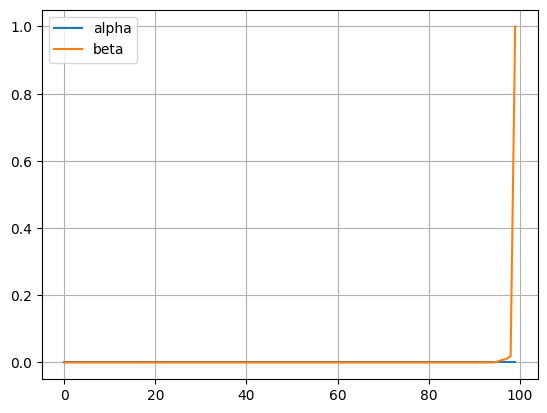

In [17]:
ax = plt.subplot(111)
n = range(x.shape[0])
ax.plot(n, alpha, label="alpha")
ax.plot(n, beta, label="beta")
# ax.plot(n, gamma, label="gamma")
ax.legend()
ax.grid()

In [20]:
# def forward(observations,
#             transition_matrix,
#             emission_matrix,
#             initial_distribution):
#     n_timesteps = observations.shape[0]
#     n_states = transition_matrix.shape[0]
#     forward_prob = np.zeros((n_timesteps, n_states))
    
#     forward_prob[0, :] = initial_distribution * emission_matrix[:, observations[0]]
    
#     for t in range(1, n_timesteps):
#         for j in range(n_states):
#             forward_prob[t, j] = (
#                 forward_prob[t-1]
#                 @ transition_matrix[:, j]
#                 * emission_matrix[j, observations[t]]
#             )
            
#     return forward_prob

# def backward(observations,
#              transition_matrix,
#              emission_matrix):
#     n_timesteps = observations.shape[0]
#     n_states = transition_matrix.shape[0]
#     backward_prob = np.zeros((n_timesteps, n_states))
    
#     backward_prob[n_timesteps-1] = np.ones((n_states))
    
#     for t in reversed(range(0, n_timesteps-1)):
#         for j in range(n_states):
#             backward_prob[t, j] = (
#                 (backward_prob[t+1]
#                  * emission_matrix[:, observations[t+1]]
#                 ) @ transition_matrix[j, :]
#             )
            
#     return backward_prob

# def baum_welch(observations,
#                transition_matrix,
#                emission_matrix,
#                initial_distribution,
#                n_iter=100):
#     n_timesteps = observations.shape[0]
#     n_states = transition_matrix.shape[0]
    
#     for n in range(n_iter):
#         # E-step
#         forward_prob = forward(
#             observations,
#             transition_matrix,
#             emission_matrix,
#             initial_distribution
#         )
#         backward_prob = backward(
#             observations,
#             transition_matrix,
#             emission_matrix
#         )
        
#         xi = np.zeros((n_states, n_states, n_timesteps-1))
        
#         for t in range(n_timesteps-1):
#             xi_denominator = (
#                 forward_prob[t, :].T
#                 @ transition_matrix
#                 * emission_matrix[:, observations[t+1]].T
#                 @ backward_prob[t+1, :]
#             )
#             for i in range(n_states):
#                 xi_numerator = (
#                     forward_prob[t, i]
#                     * transition_matrix[i, :]
#                     * emission_matrix[:, observations[t+1]].T
#                     * backward_prob[t+1, :].T
#                 )
#                 xi[i, :, t] = xi_numerator / xi_denominator
                
#         gamma = np.sum(xi, axis=1)
        
#         # M-step
#         transition_matrix = np.sum(xi, axis=2) / np.sum(gamma, axis=1).reshape((-1, 1))
    
#         gamma = np.hstack((gamma, np.sum(xi[:, :, n_timesteps-2], axis=0).reshape((-1, 1))))
#         n_symbols = emission_matrix.shape[1]
#         denominator = np.sum(gamma, axis=1)
        
#         for i in range(n_symbols):
#             emission_matrix[:, i] = np.sum(gamma[:, observations == i], axis=1)
 
#         emission_matrix = np.divide(emission_matrix, denominator.reshape((-1, 1)))
 
#     return (transition_matrix, emission_matrix)


In [21]:
# A_est, B_est = baum_welch(x, A_transition, B_emission, pi)
# print(f"A:\n{A_est}")
# print(f"B:\n{B_est}")